# Search Space

**THIS IS THE MOST IMPORTANT CONCEPT OF TUNE, MUST READ**

Tune defines its own searching space concept and different expressions. It inherits the Fugue philosophy: one expression for all frameworks. For the underlying optimizers (e.g. HyperOpt, Optuna), tune unifies the behaviors. For example `Rand(1.0, 5.0, q=1.5)` will uniformly search on `[1.0 , 2.5, 4.0]` no matter you use HyperOpt or Optuna as the underlying optimizer.

In Tune, spaces are predefined before search, it is opposite to Optuna where you get variables inside objectives during runtime. In this way, your space definition is totally separated from objective definition, and your objectives may be just simple python functions independent from Tune.

In [1]:
from tune import Space, Grid, Rand, RandInt, Choice
import pandas as pd

## Simple Cases

The simplest cases are spaces with only static variables. So the spaces will always generate single configuration.

In [2]:
space = Space(a=1, b=1)
print(list(space))

[{'a': 1, 'b': 1}]


## Grid Search

You can replace the static variables to `Grid` expression. We will cross product all grid expressions in the space, so you see in the second example, it generates 6 configurations.

In [3]:
print(list(Space(a=1, b=Grid("a","b"))))
print(list(Space(a=Grid(1,2), b=Grid("x","y","z"))))

[{'a': 1, 'b': 'a'}, {'a': 1, 'b': 'b'}]
[{'a': 1, 'b': 'x'}, {'a': 1, 'b': 'y'}, {'a': 1, 'b': 'z'}, {'a': 2, 'b': 'x'}, {'a': 2, 'b': 'y'}, {'a': 2, 'b': 'z'}]


## Random Expressions

Random search requires `.sample` method after you define the original space to specify how many random combinations you want to draw from the expression.

### Choice

`Choice` refers to discrete **unordered** set of values. So `Choice(1, 2, 3)` is equivalent to `Choide(2, 1, 3)`. When you do random sampling from `Choice`, every value has equal chance. When you do advanced search such as Bayesian Optimization, it also assumes no relation between values.

In [4]:
space = Space(a=1, b=Choice("aa", "bb", "cc")).sample(2, seed=1)
print(list(space))

[{'a': 1, 'b': 'bb'}, {'a': 1, 'b': 'aa'}]


### Rand

`Rand` is the most common expression for a variable. It refers to sampling from a range of value.

#### Rand(low, high)

uniformly search between `[low, high)`

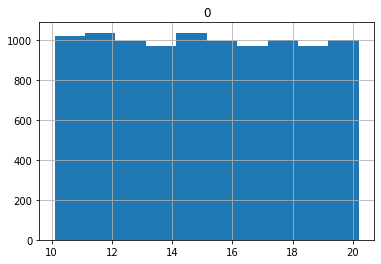

In [5]:
samples = Rand(10.1, 20.2).generate_many(10000, seed=0)
pd.DataFrame(samples).hist();

#### Rand(low, high, log=True)

search in the log space, but still in `[low, high)` so the smaller values get higher chance to be selected.

For log space searching, low must be greater or equal to 1.

The algorithm: `exp(uniform(log(low), log(high)))`

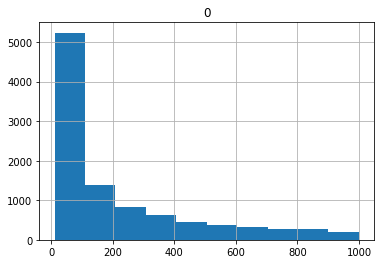

In [6]:
samples = Rand(10.1, 1000, log=True).generate_many(10000, seed=0)
pd.DataFrame(samples).hist();

#### Rand(low, high, q, include_high)

uniformly search between `low` and `high` with step `q`. `include_high` (default `True`) indicates whether the high value can be a candidate.

[1.5, 4.0, 1.5, 1.5, 1.5, 1.5, 1.5, 4.0, 4.0, 1.5]
[1.5, 1.5, 1.5, 1.5, -1.0, 1.5, -1.0, 1.5, 1.5, -1.0]


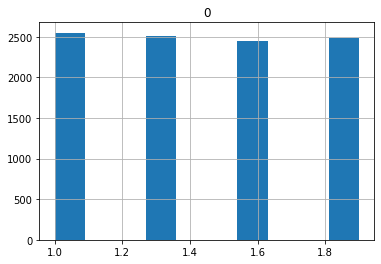

In [7]:
print(Rand(-1.0,4.0,q=2.5).generate_many(10, seed=0))
print(Rand(-1.0,4.0,q=2.5,include_high=False).generate_many(10, seed=0))

samples = Rand(1.0,2.0,q=0.3).generate_many(10000, seed=0)
pd.DataFrame(samples).hist();

#### Rand(low, high, q, include_high, log=True)

search between `low` and `high` with step `q` in log space. `include_high` (default `True`) indicates whether the high value can be a candidate.

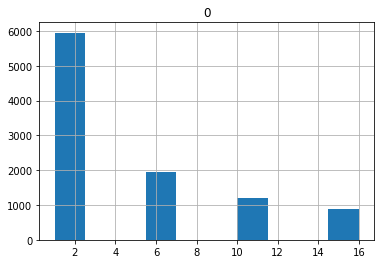

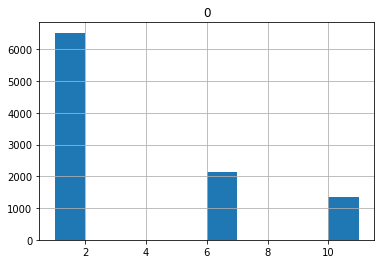

In [8]:
samples = Rand(1.0,16.0,q=5, log=True).generate_many(10000, seed=0)
pd.DataFrame(samples).hist()

samples = Rand(1.0,16.0,q=5, log=True, include_high=False).generate_many(10000, seed=0)
pd.DataFrame(samples).hist();

### RandInt

`RandInt` can be considered as a special case of `Rand` where the `low`, `high` and `q` are all integers

#### RandInt(low, high, include_high)

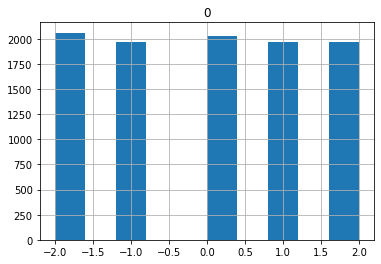

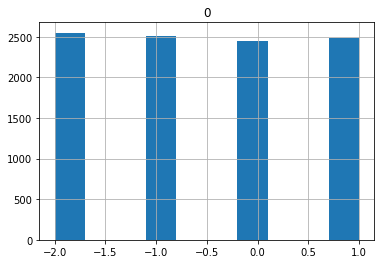

In [9]:
samples = RandInt(-2,2).generate_many(10000, seed=0)
pd.DataFrame(samples).hist()

samples = RandInt(-2,2,include_high=False).generate_many(10000, seed=0)
pd.DataFrame(samples).hist();

#### RandInt(low, high, include_high, q)

Search starting from `low` with step `q` to `high`

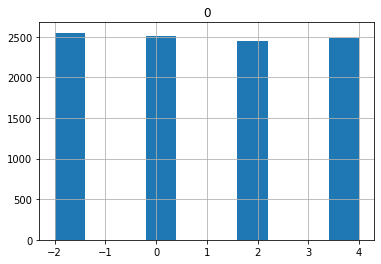

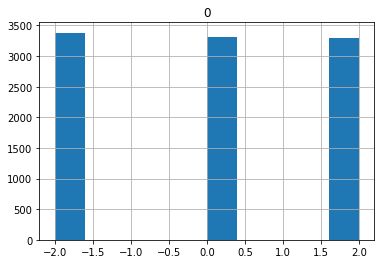

In [10]:
samples = RandInt(-2,4,q=2).generate_many(10000, seed=0)
pd.DataFrame(samples).hist()

samples = RandInt(-2,4,include_high=False,q=2).generate_many(10000, seed=0)
pd.DataFrame(samples).hist();

#### RandInt(low, high, include_high, q, log)

Search starting from `low` with step `q` to `high`. The difference is it's in log space, so lower values get higher chance.

Also for log searching space, `low` must be `>=1`


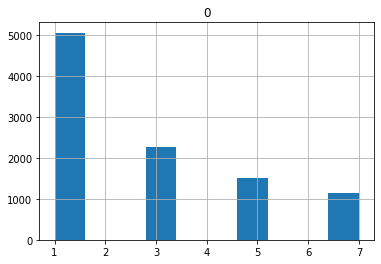

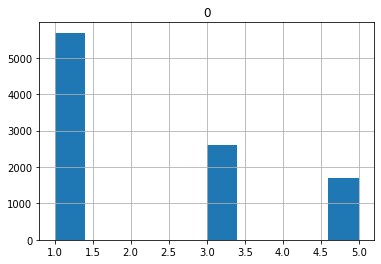

In [11]:
samples = RandInt(1,7,q=2,log=True).generate_many(10000, seed=0)
pd.DataFrame(samples).hist()

samples = RandInt(1,7,include_high=False,q=2,log=True).generate_many(10000, seed=0)
pd.DataFrame(samples).hist();

## Random Search

In Tune, you have two options to search on random expressions

### As Level 1 Search

Level 1 means before execution. So given a combination of random expressions, we draw certain number of parameter combinations before execution. So the system will only deal with static parameters during runtime.

Grid search is also Level 1 search, and Level 1 search determines max parallelism. To also treat random expressions as Level 1, we must use `.sample`

In [12]:
space = Space(a=Rand(0,1), b=Choice("x", "y")).sample(10, seed=0)
list(space)

[{'a': 0.5488135039273248, 'b': 'x'},
 {'a': 0.7151893663724195, 'b': 'y'},
 {'a': 0.6027633760716439, 'b': 'y'},
 {'a': 0.5448831829968969, 'b': 'x'},
 {'a': 0.4236547993389047, 'b': 'x'},
 {'a': 0.6458941130666561, 'b': 'y'},
 {'a': 0.4375872112626925, 'b': 'y'},
 {'a': 0.8917730007820798, 'b': 'y'},
 {'a': 0.9636627605010293, 'b': 'y'},
 {'a': 0.3834415188257777, 'b': 'x'}]

If in space, you have both grid and random expressions, `.sample` will only apply to random samples, and then cross product with all grid combinations

In [13]:
space = Space(a=Grid(0,1), b=Rand(0,1), c=Grid("a", "b"), d=Rand(0,1)).sample(3, seed=1)
list(space)  # 2*2 *3 configs

[{'a': 0, 'b': 0.417022004702574, 'c': 'a', 'd': 0.30233257263183977},
 {'a': 0, 'b': 0.417022004702574, 'c': 'b', 'd': 0.30233257263183977},
 {'a': 1, 'b': 0.417022004702574, 'c': 'a', 'd': 0.30233257263183977},
 {'a': 1, 'b': 0.417022004702574, 'c': 'b', 'd': 0.30233257263183977},
 {'a': 0, 'b': 0.7203244934421581, 'c': 'a', 'd': 0.14675589081711304},
 {'a': 0, 'b': 0.7203244934421581, 'c': 'b', 'd': 0.14675589081711304},
 {'a': 1, 'b': 0.7203244934421581, 'c': 'a', 'd': 0.14675589081711304},
 {'a': 1, 'b': 0.7203244934421581, 'c': 'b', 'd': 0.14675589081711304},
 {'a': 0, 'b': 0.00011437481734488664, 'c': 'a', 'd': 0.0923385947687978},
 {'a': 0, 'b': 0.00011437481734488664, 'c': 'b', 'd': 0.0923385947687978},
 {'a': 1, 'b': 0.00011437481734488664, 'c': 'a', 'd': 0.0923385947687978},
 {'a': 1, 'b': 0.00011437481734488664, 'c': 'b', 'd': 0.0923385947687978}]

### As Level 2 Search

Level 2 search happens during runtime, and bases on each level 1 search candidate. A common scenario is that we want to do grid search on one parameter, and do Bayesian Optimization on another parameter. Then we can parallelize on the choices of the first parameter and do sequential Bayesian Optimization on the second parameter.

We will use 3rd party solutions for Level 2 search, such as HyperOpt and Optuna. To pass random expression to Level 2, we simply don't use `.sample`

In [14]:
space = Space(a=Grid(0,1), b=Rand(0,1), c=Grid("a", "b"), d=Rand(0,1))
list(space)  # 2*2 configs, each of the config still contains the Rand expression

[{'a': 0, 'b': Rand(low=0, high=1, q=None, log=False, include_high=True), 'c': 'a', 'd': Rand(low=0, high=1, q=None, log=False, include_high=True)},
 {'a': 0, 'b': Rand(low=0, high=1, q=None, log=False, include_high=True), 'c': 'b', 'd': Rand(low=0, high=1, q=None, log=False, include_high=True)},
 {'a': 1, 'b': Rand(low=0, high=1, q=None, log=False, include_high=True), 'c': 'a', 'd': Rand(low=0, high=1, q=None, log=False, include_high=True)},
 {'a': 1, 'b': Rand(low=0, high=1, q=None, log=False, include_high=True), 'c': 'b', 'd': Rand(low=0, high=1, q=None, log=False, include_high=True)}]

## Space Operations, Conditional Search and Hybrid Search

Almost all popular tuning frameworks support conditional search. `Tune` approaches conditional search in a totally different way.

Instead using if-else at runtime or using nested dictionaries to represent conditions, we introduce space operations:


In [15]:
space1 = Space(a=1, b=Grid(2,3))
space2 = Space(c=Grid("a","b"))

union_space = space1 + space2
print(list(union_space))

product_space = space1 * space2
print(list(product_space))

[{'a': 1, 'b': 2}, {'a': 1, 'b': 3}, {'c': 'a'}, {'c': 'b'}]
[{'a': 1, 'b': 2, 'c': 'a'}, {'a': 1, 'b': 2, 'c': 'b'}, {'a': 1, 'b': 3, 'c': 'a'}, {'a': 1, 'b': 3, 'c': 'b'}]


Operator `+` will **union** the configurations from two spaces, it can solve most of the conditional search problems

Operator `*` will **cross product** the configurations from two spaces, it can solve most of the hybrid search problems

### Conditional Search

In [16]:
space1 = Space(model="LogisticRegression")
space2 = Space(model="RandomForestClassifier", max_depth=Grid(3,4))
space3 = Space(model="XGBClassifier", n_estimators=Grid(10,100,1000))

sweep = sum([space1, space2, space3])  # sum is another way to union
list(sweep)

[{'model': 'LogisticRegression'},
 {'model': 'RandomForestClassifier', 'max_depth': 3},
 {'model': 'RandomForestClassifier', 'max_depth': 4},
 {'model': 'XGBClassifier', 'n_estimators': 10},
 {'model': 'XGBClassifier', 'n_estimators': 100},
 {'model': 'XGBClassifier', 'n_estimators': 1000}]

All 3 models have a parameter `random_state`, we want also want to do a grid search on it for every model. We just use `*`

In [17]:
sweep_with_random_state = sweep * Space(random_state=Grid(0,1))
list(sweep_with_random_state)

[{'model': 'LogisticRegression', 'random_state': 0},
 {'model': 'LogisticRegression', 'random_state': 1},
 {'model': 'RandomForestClassifier', 'max_depth': 3, 'random_state': 0},
 {'model': 'RandomForestClassifier', 'max_depth': 3, 'random_state': 1},
 {'model': 'RandomForestClassifier', 'max_depth': 4, 'random_state': 0},
 {'model': 'RandomForestClassifier', 'max_depth': 4, 'random_state': 1},
 {'model': 'XGBClassifier', 'n_estimators': 10, 'random_state': 0},
 {'model': 'XGBClassifier', 'n_estimators': 10, 'random_state': 1},
 {'model': 'XGBClassifier', 'n_estimators': 100, 'random_state': 0},
 {'model': 'XGBClassifier', 'n_estimators': 100, 'random_state': 1},
 {'model': 'XGBClassifier', 'n_estimators': 1000, 'random_state': 0},
 {'model': 'XGBClassifier', 'n_estimators': 1000, 'random_state': 1}]

### Hybrid Search (Grid + Random + Bayesian Optimization)

For `XGBClassifier`, we want to do a hybrid search: grid search on `random_state`, random search on `n_estimators` and Level 2 (Bayesian Optimization) search on `learning_rate`

In [18]:
xgb = Space(model="XGBClassifier", learning_rate=Rand(0,1), random_state=Grid(0,1)) * Space(n_estimators=RandInt(10,1000)).sample(3, seed=0)
list(xgb)

[{'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 0, 'n_estimators': 553},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 0, 'n_estimators': 718},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 0, 'n_estimators': 607},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 1, 'n_estimators': 553},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 1, 'n_estimators': 718},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 1, 'n_estimators': 607}]

Hybrid search and conditional search can also be used together

In [19]:
list(Space(model="LogisticRegression")+xgb)

[{'model': 'LogisticRegression'},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 0, 'n_estimators': 553},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 0, 'n_estimators': 718},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 0, 'n_estimators': 607},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 1, 'n_estimators': 553},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 1, 'n_estimators': 718},
 {'model': 'XGBClassifier', 'learning_rate': Rand(low=0, high=1, q=None, log=False, include_high=True), 'random_state': 1, 'n_estimators': 607}]